<h1> Here we will be focusing more on the cnmf part and its main functions <h1>

In [2]:
try:
    if __IPYTHON__:
        # this is used for debugging purposes only. allows to reload classes when changed
        get_ipython().magic(u'load_ext autoreload')
        get_ipython().magic(u'autoreload 2')
except NameError:       
    print('Not IPYTHON')    
    pass

import sys
import numpy as np
from time import time
from scipy.sparse import coo_matrix
import psutil
import glob
import os
import scipy
from ipyparallel import Client
#import matplotlib as mpl
#mpl.use('TkAgg')

import pylab as pl
#pl.ion()

import caiman as cm
from caiman.components_evaluation import evaluate_components
from caiman.utils.visualization import plot_contours,view_patches_bar,nb_plot_contour,nb_view_patches
from caiman.base.rois import extract_binary_masks_blob
import caiman.source_extraction.cnmf as cnmf

numba not found


In [1]:
#import bokeh.plotting as bp
import bokeh.plotting as bpl
try:
       from bokeh.io import vform, hplot
except:
       # newer version of bokeh does not use vform & hplot, instead uses column & row
       from bokeh.layouts import column as vform
       from bokeh.layouts import row as hplot
from bokeh.models import CustomJS, ColumnDataSource, Slider
from IPython.display import display, clear_output
import matplotlib as mpl
import matplotlib.cm as cmap
import numpy as np

bpl.output_notebook()

ImportError: No module named bokeh.plotting

<h1> Using the workload manager SLURM </h1> 
to have an extensive use of the machine. 
<p> This is to be used when working with a cluster of machines 
<img src="docs/img/Dockerfile.gif"/>
</p><p>This will put dispatch and manage the workload gave by the algorithm : <img src="docs/img/node.gif" /></p>
<p> learn more : <em> https://slurm.schedmd.com/overview.html </em> </p>

In [4]:
# frame rate in Hz
final_frate=10 
#backend='SLURM'
backend='local'
if backend == 'SLURM':
    n_processes = np.int(os.environ.get('SLURM_NPROCS'))
else:
    n_processes = np.maximum(np.int(psutil.cpu_count()),1) # roughly number of cores on your machine minus 1
print 'using ' + str(n_processes) + ' processes'
#%% start cluster for efficient computation
single_thread=False

if single_thread:
    dview=None
else:    
    try:
        c.close()
    except:
        print 'C was not existing, creating one'
    print "Stopping  cluster to avoid unnencessary use of memory...."
    sys.stdout.flush()  
    if backend == 'SLURM':
        try:
            cm.stop_server(is_slurm=True)
        except:
            print 'Nothing to stop'
        slurm_script='/mnt/xfs1/home/agiovann/SOFTWARE/Constrained_NMF/SLURM/slurmStart.sh'
        cm.start_server(slurm_script=slurm_script)
        pdir, profile = os.environ['IPPPDIR'], os.environ['IPPPROFILE']
        c = Client(ipython_dir=pdir, profile=profile)        
    else:
        cm.stop_server()
        cm.start_server()        
        c=Client()

    print 'Using '+ str(len(c)) + ' processes'
    dview=c[:len(c)]

using 4 processes
Stopping  cluster to avoid unnencessary use of memory....
Stopping cluster...
NOT SLURM
/bin/sh: ipcluster: command not found

**** Unrecognized Syntax in ipcluster output, waiting for server to stop anyways ****
 done
Starting cluster...Using 4 processes


<b> We can see here that the number of processes are the number of core your computer possess. <br/> Your computer can be seen as a node that possess X cores </b>

<h1> doing a F order mapping</h1>
<p> see : https://github.com/simonsfoundation/CaImAn/blob/master/demo_caiman_pipeline.ipynb </p>
<img src="docs/img/Fordermmap.png" /> 

In [5]:
#%% FOR LOADING ALL TIFF FILES IN A FILE AND SAVING THEM ON A SINGLE MEMORY MAPPABLE FILE
fnames=[]
base_folder='./example_movies/' # folder containing the demo files
for file in glob.glob(os.path.join(base_folder,'*.tif')):
    if file.endswith("ie.tif"):
        fnames.append(os.path.abspath(file))
fnames.sort()
  
fnames=fnames
downsample_factor=1 # use .2 or .1 if file is large and you want a quick answer
final_frate=final_frate*downsample_factor
idx_xy=None
base_name='Yr'
name_new=cm.save_memmap_each(fnames
        , dview=dview,base_name=base_name, resize_fact=(1, 1, downsample_factor)
        , remove_init=0,idx_xy=idx_xy )
name_new.sort()
fname_new=cm.save_memmap_join(name_new,base_name='Yr', n_chunks=12, dview=dview)
print fnames
print fname_new
print "\n we can see we are loading the file (line1) into a memorymapped object (line2)"

('/Users/jeremie/CaImAn/example_movies/Yr0000_d1_60_d2_80_d3_1_order_C_frames_2000_.mmap', 2000)
/Users/jeremie/CaImAn/example_movies/Yr_d1_60_d2_80_d3_1_order_C_frames_2000_.mmap
Deleting big mov
['/Users/jeremie/CaImAn/example_movies/demoMovie.tif']
/Users/jeremie/CaImAn/example_movies/Yr_d1_60_d2_80_d3_1_order_C_frames_2000_.mmap

 we can see we are loading the file (line1) into a memorymapped object (line2)


<h2> we are now visualizing the correlation image throught time of the video</h2>


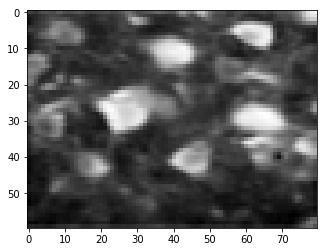

In [6]:
#%%
Yr,dims,T=cm.load_memmap(fname_new)
Y=np.reshape(Yr,dims+(T,),order='F')
#%% visualize correlation image
Cn = cm.local_correlations(Y)
pl.imshow(Cn,cmap='gray') 
pl.show()

In [7]:
#%% parameters of experiment
K=30 # number of neurons expected per patch
gSig=[6,6] # expected half size of neurons
merge_thresh=0.8 # merging threshold, max correlation allowed
p=2 #order of the autoregressive system
options = cnmf.utilities.CNMFSetParms(Y
        ,n_processes,p=p,gSig=gSig,K=K,ssub=2,tsub=2, normalize_init=True)

using 4 processes
using 1000 pixels per process
using 1000 block_size


 CNMFSetParms define Dictionaries of CNMF parameters.
 Any parameter that is not set get a default value specified.
 
     each dictionnary is used by different part of the CNMF process : 
 - init_paramters
 - pre_processing_parameters
 - patch_parameters
 - spatial_parameters
 - temporal_parameters
    

<h2> Preprocessing of the datas and initialization of the components </h2>
<ul><li> here, we compute the mean of the noise spectral density </li>
<li> then, we initialize each component with a greedy ROI algorithm on component that have been spatially filter using a gaussian kernel </li>
<li> we then further update the component using Hals method on the newly obtained nmf paramters</ul>
<p> see More : NMF AND ROI :http://www.cell.com/neuron/fulltext/S0896-6273(15)01084-3<br\> </p>


In [39]:
Yr,sn,g,psx = cnmf.pre_processing.preprocess_data(Yr
            ,dview=dview
            ,n_pixels_per_process=100,  noise_range = [0.25,0.5]
            ,noise_method = 'logmexp', compute_g=False,  p = 2
            ,g = None,  lags = 5, include_noise = False, pixels = None
            ,max_num_samples_fft=3000, check_nan = True)

Ain, Cin, b_in, f_in, center=cnmf.initialization.initialize_components(Y
            ,K=30, gSig=[5, 5], gSiz=None, ssub=1, tsub=1, nIter=5, maxIter=5, nb=1
            , use_hals=False, normalize_init=True, img=None, method='greedy_roi'
            , max_iter_snmf=500, alpha_snmf=10e2, sigma_smooth_snmf=(.5, .5, .5)
            , perc_baseline_snmf=20)
p1=nb_plot_contour(Cn,Ain,dims[0],dims[1],thr=0.9,face_color=None
                    , line_color='black',alpha=0.4,line_width=2)
bpl.show(p1)

checking if missing data
Running on 4 engines.
Noise Normalization
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
(Hals) Refining Components...


<h2> HALS </h2>
we want to minimize
<img src=docs/img/hals1.png width=300px/>
updating parameters
<img src=docs/img/hals2.png width=300px />
<p>HALS : http://proceedings.mlr.press/v39/kimura14.pdf</p>


In [11]:
Ain, Cin, b_in, f_in = cnmf.initialization.hals(Y, Ain, Cin, b_in, f_in, maxIter=5)
p1=nb_plot_contour(Cn,Ain,dims[0],dims[1],thr=0.9,face_color=None
                    , line_color='black',alpha=0.4,line_width=2)
bpl.show(p1)

caiman/utils/visualization.py:880: UserWarning: The way to call utilities.plot_contours has changed. Look at the definition for more details.
  warn("The way to call utilities.plot_contours has changed. Look at the definition for more details.")


In [12]:
#%% UPDATE SPATIAL COMPONENTS
pl.close()
t1 = time()
A,b,Cin,f_in = cnmf.spatial.update_spatial_components(Yr, Cin, f_in, Ain, sn=sn, dview=dview,**options['spatial_params'])
t_elSPATIAL = time() - t1
print t_elSPATIAL 
#clear_output(wait=True)
print('DONE!')

found spatial support for each component
(4800, 30)
Starting Update Spatial Components
Updated Spatial Components
threshold
Computing residuals
parallel dot product block size: 1000
Start product
Filling
Computing A_bas
--- 7.20145916939 seconds ---
Remove temporary file created
7.22862410545
DONE!


In [1]:
pl.figure(num=None, figsize=(9, 7), dpi=100, facecolor='w', edgecolor='k')
crd = plot_contours(A,Cn,thr=0.9)
pl.show()

NameError: name 'pl' is not defined

In [ ]:
p1=nb_plot_contour(Cn,A.todense(),dims[0],dims[1],thr=0.9,face_color=None, line_color='black',alpha=0.4,line_width=2)
bpl.show(p1)

In [15]:
pl.close()
t1 = time()
options['temporal_params']['p'] = 0 # set this to zero for fast updating without deconvolution
C,A,b,f,S,bl,c1,neurons_sn,g,YrA = cnmf.temporal.update_temporal_components(Yr,A,b,Cin,f_in,bl=None,c1=None,sn=None,g=None,**options['temporal_params'])
t_elTEMPORAL = time() - t1
print t_elTEMPORAL  
clear_output(wait=True)

Generating residuals
Forcing single thread for memory issues
parallel dot product block size: 1000
Start product
Transposing
999
1999
2999
3999
4799
Done
0
7 out of total 30 temporal components updated
13 out of total 30 temporal components updated
19 out of total 30 temporal components updated
25 out of total 30 temporal components updated
28 out of total 30 temporal components updated
30 out of total 30 temporal components updated
7 out of total 30 temporal components updated
13 out of total 30 temporal components updated
19 out of total 30 temporal components updated
25 out of total 30 temporal components updated
28 out of total 30 temporal components updated
30 out of total 30 temporal components updated
stopping: overall temporal component not changing significantly
0.581013917923


In [16]:
#%% merge components corresponding to the same neuron
t1 = time()
A_m,C_m,nr_m,merged_ROIs,S_m,bl_m,c1_m,sn_m,g_m=cnmf.merging.merge_components(Yr,A,b,C,f,S,sn,options['temporal_params'], options['spatial_params'],dview=dview, bl=bl, c1=c1, sn=neurons_sn, g=g, thr=merge_thresh, mx=50, fast_merge = True)
t_elMERGE = time() - t1
print t_elMERGE

********** No neurons merged! ***************
done merging
0.06968998909


/Users/jeremie/anaconda2/envs/CaImAn/lib/python2.7/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [17]:
#refine spatial and temporal components
pl.close()
t1 = time()
A2,b2,C2,f = cnmf.spatial.update_spatial_components(Yr, C_m, f, A_m, sn=sn,dview=dview, **options['spatial_params'])
options['temporal_params']['p'] = p # set it back to original value to perform full deconvolution
C2,A2,b2,f2,S2,bl2,c12,neurons_sn2,g21,YrA = cnmf.temporal.update_temporal_components(Yr,A2,b2,C2,f,dview=dview, bl=None,c1=None,sn=None,g=None,**options['temporal_params'])
clear_output(wait=True)
print time() - t1 # 100 seconds
print('DONE!')

10.1812820435
DONE!


In [18]:
tB = np.minimum(-2,np.floor(-5./30*final_frate))
tA = np.maximum(5,np.ceil(25./30*final_frate))
Npeaks=10
traces=C2+YrA
#        traces_a=traces-scipy.ndimage.percentile_filter(traces,8,size=[1,np.shape(traces)[-1]/5])
#        traces_b=np.diff(traces,axis=1)
fitness_raw, fitness_delta, erfc_raw, erfc_delta, r_values, significant_samples = \
    evaluate_components(Y, traces, A, C, b, f, final_frate, remove_baseline=True,
                                      N=5, robust_std=False, Athresh=0.1, Npeaks=Npeaks,  thresh_C=0.3)
    
idx_components_r=np.where(r_values>=.6)[0]
idx_components_raw=np.where(fitness_raw<-60)[0]        
idx_components_delta=np.where(fitness_delta<-20)[0]   


min_radius=gSig[0]-2
masks_ws,idx_blobs,idx_non_blobs=extract_binary_masks_blob(
A2.tocsc(), min_radius, dims, num_std_threshold=1, 
minCircularity= 0.6, minInertiaRatio = 0.2,minConvexity =.8)




idx_components=np.union1d(idx_components_r,idx_components_raw)
idx_components=np.union1d(idx_components,idx_components_delta)  
idx_blobs=np.intersect1d(idx_components,idx_blobs)   
idx_components_bad=np.setdiff1d(range(len(traces)),idx_components)
clear_output(wait=True)
print(' ***** ')
print len(traces)
print(len(idx_components))
print(len(idx_blobs))

 ***** 
30
24
14


(60, 80)


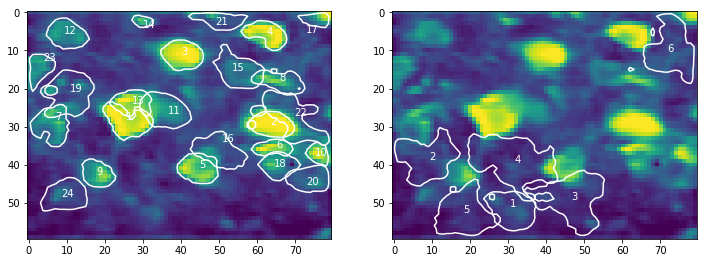

In [19]:
fg=pl.figure(figsize=(12,20))
pl.subplot(1,2,1)
crd = plot_contours(A2.tocsc()[:,idx_components],Cn,thr=0.9)
pl.subplot(1,2,2)
crd = plot_contours(A2.tocsc()[:,idx_components_bad],Cn,thr=0.9)
print dims

In [20]:
p2=nb_plot_contour(Cn,A2.tocsc()[:,idx_components].todense(),dims[0],dims[1],thr=0.9,face_color='purple', line_color='black',alpha=0.3,line_width=2)
bpl.show(p2)

In [22]:
true_traces_fluo=nb_view_patches(Yr,A2.tocsc()[:,idx_components],C2[idx_components],b2,f2,dims[0],dims[1],thr = 0.9,image_neurons=None, denoised_color='green')

Loading BokehJS ...

Loading BokehJS ...

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [25]:
discard_traces_fluo=nb_view_patches(Yr,A2.tocsc()[:,idx_components_bad],C2[idx_components_bad],b2,f2,dims[0],dims[1],thr = 0.8,image_neurons=Cn, denoised_color='red')

Loading BokehJS ...

In [97]:
#%% STOP CLUSTER
cm.stop_server()

Stopping cluster...
NOT SLURM
Waiting for cluster to stop....... done


NameError: name 'a' is not defined